### Importamos las librerias.

In [4]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from datasets import load_dataset_builder 
from datasets import load_dataset
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from datetime import datetime
from dateutil.parser import parse
import numpy as np
from tqdm import tqdm
#import tensorflow as tf
from  tp_function import  clean_all, Cleaning_text
from  tp_function import load_dataset_function, limpieza_entidades, limpieza_keywords, limpieza_texto, train_function, threshold_function, tabla_frecuencia #(*)

c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [5]:
from opensearch_data_model import Topic, TopicKeyword, os_client

In [6]:
Topic.init()


### Levantamos y guardamos en disco los Dataset. Nos quedamos solo con los que tienen fecha correcta.


In [ ]:
date_choice = '2024-07-15' 
df_1 = load_dataset_function(date_choice)
df_1.to_parquet(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+"\df_1.parquet")
df_1.head(1)

In [7]:
df_1 = pd.read_parquet(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+"\df_1.parquet")


In [ ]:
date_choice = '2024-07-20'    
df_2 = load_dataset_function(date_choice)
df_2.to_parquet(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+"\df_2.parquet")
df_2.head(1)

In [8]:
df_2 = pd.read_parquet(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+"\df_2.parquet")

In [9]:
df_1[["entities" ,  "keywords", "text"]].head(2)
df_2[["entities" ,  "keywords", "text"]].head(2)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


,entities,keywords,text
963,"[Julio Cobos, C, Presidente, Martín Tetaz, Cri...","[propinas, proyecto similar, propina, tarjeta,...",Un proyecto busca que las propinas se incluyan...
1161,"[Eliana, Rubén, Marcela, Susi, Angela, Gerardo...","[un hogar, muchísimos amigos, mis amigas, conf...","Lidia Furlani y Natividad Muñoz, que viven en ..."


### Achico los dataset para reducir tiempo de entrenamiemto

In [10]:
batch_news = 500

df_train_1 = df_1.sample(n=int(batch_news)).copy()
df_train_2 = df_2.sample(n=int(batch_news)).copy()

print(f" Cantidad de noticias de df_1 para entrenar el modelo es {len(df_train_1)}")
print(f" Cantidad de noticias de df_2 para entrenar el modelo es {len(df_train_2)}")

 Cantidad de noticias de df_1 para entrenar el modelo es 500
 Cantidad de noticias de df_2 para entrenar el modelo es 500


In [11]:
df_train_1[["entities" ,  "keywords", "text"]].head(2)

,entities,keywords,text
10392,"[Néstor Kirchner, Karina, Mauricio Macri, Mile...","[alto impacto, el expresidente, los hermanos, ...",Por: Por Pablo Ibánez\n\nVictoria Villarruel e...
7584,"[Guillermo Raúl Montes, Infocielo]","[auto, vehículo, corsa, tragedia, luxación, ba...","Una nena se arrojó de un auto en Ramallo y, cu..."


### StopWords 

In [13]:
SPANISH_STOPWORDS = list(pd.read_csv('stop_words_spanish.csv' )['stopwords'].values)
SPANISH_STOPWORDS_PARTICULAR = list(pd.read_csv('stop_words_particular.csv' )['stopwords'].values)
#SPANISH_STOPWORDS_PARTICULAR. Falta  Completar a mano

### Entidades y KeyWords con una pequeña limpieza.


In [14]:
enti_train_1 = limpieza_entidades(df_train_1, SPANISH_STOPWORDS, SPANISH_STOPWORDS_PARTICULAR)
print(len(enti_train_1))
enti_train_1[:5]


2979


['europa press', 'secretaría de turismo', 'cnv', 'nesta', 'ceferino namuncurá']

In [15]:
enti_train_2 = limpieza_entidades(df_train_2,SPANISH_STOPWORDS, SPANISH_STOPWORDS_PARTICULAR)
print(len(enti_train_2))
enti_train_2[:5]


3352


['darío benedetto',
 'secretaría de turismo',
 'nahuel barrios',
 'barcelona',
 'carolina domenech']

In [16]:
key_train_1 = limpieza_keywords(df_train_1, SPANISH_STOPWORDS, SPANISH_STOPWORDS_PARTICULAR)
print(len(key_train_1))
key_train_1[:2]


9193


['ex ministro', 'anécdota familiar']

In [17]:
key_train_2 = limpieza_keywords(df_train_2, SPANISH_STOPWORDS, SPANISH_STOPWORDS_PARTICULAR)
print(len(key_train_2))
key_train_2[:2]


9775


['ejercicios', 'espejo']

### Armo el vocabulario 

In [18]:
vocab_1 =  list(set(key_train_1 + enti_train_1))
vocab_2 =  list(set(key_train_2 + enti_train_2))

### TF-IDF

In [19]:
from typing import Callable, Iterable, Literal, Mapping   

In [25]:
data_train_1 = list(df_train_1['text']) 
tfidf_vectorizer_1 = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 3),
        vocabulary=vocab_1,
)
tfidf_vectorizer_1.fit(data_train_1)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 3),
                vocabulary=['cnv', 'ex ministro', 'anécdota familiar', 'espejo',
                            'eloy elgueta', 'defensa jorge',
                            'arístides villanueva', 'estrellas',
                            'sencilla operación', 'frío',
                            'trabajadores municipales', 'receso invernal',
                            'falsas promesas', 'guillermo gammacurta',
                            'aplicación', 'mesa distinta', 'exposición',
                            'raúl jalil', 'ahínco', 'música popular',
                            'una generación', 'horror', 'sociedades',
                            'texto oculta', 'la acusación', 'la realidad',
                            'motivaciones', 'julián alvarez',
                            'santiago maggiotti', 'gandolfo', ...])

In [26]:
data_train_2= list(df_train_2['text'])

tfidf_vectorizer_2 = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 3),
        vocabulary=vocab_2,
)

tfidf_vectorizer_2.fit(data_train_2)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 3),
                vocabulary=['ejercicios', 'espejo', 'violadores', 'mártir',
                            'garganta', 'carolina domenech', 'el maíz',
                            'estrellas', 'masiva llegada', 'vélez',
                            'receso invernal', 'futuro goleador',
                            'falsas promesas', 'empleados de comercio',
                            'guillermo gammacurta', 'oim', 'ucla', 'aplicación',
                            'aoma', 'competencia interna', 'aula', 'exposición',
                            'bombardeos israelíes', 'apa', 'ecografías',
                            'san nicolás', 'horror', 'diversos episodios',
                            'sociedades', 'profesionales altamente capacitados', ...])

### Limpio el texto de las noticias.

In [21]:
proc_data_text_1 =  limpieza_texto(df_train_1, SPANISH_STOPWORDS, SPANISH_STOPWORDS_PARTICULAR)
proc_data_text_2 =  limpieza_texto(df_train_2, SPANISH_STOPWORDS, SPANISH_STOPWORDS_PARTICULAR)
    

100%|██████████| 500/500 [00:02<00:00, 218.11it/s]


### Inicializamos el modelo para los corpus 1 y 2.  

In [22]:
#Pasos Comunes. 

#Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

In [28]:
# Step 4 - Tokenize topics
vectorizer_model_1= tfidf_vectorizer_1



topic_model_1 = BERTopic(
  embedding_model=embedding_model,              
  umap_model=umap_model,                        
  hdbscan_model=hdbscan_model,                  
  vectorizer_model=vectorizer_model_1,         
  ctfidf_model=ctfidf_model,                    
  verbose=True,
  #calculate_probabilities=True
)



In [27]:
# Step 4 - Tokenize topics
vectorizer_model_2= tfidf_vectorizer_2

topic_model_2 = BERTopic(
  embedding_model=embedding_model,              
  umap_model=umap_model,                        
  hdbscan_model=hdbscan_model,                  
  vectorizer_model=vectorizer_model_2,         
  ctfidf_model=ctfidf_model,                    
  verbose=True,
  #calculate_probabilities=True
)

### Entrenamiento y guardado.

In [29]:
topics_1, probs_1 = train_function(topic_model_1, proc_data_text_1)
topics_2, probs_2 = train_function(topic_model_2, proc_data_text_2)

2024-09-30 11:18:59,262 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-09-30 11:19:54,151 - BERTopic - Embedding - Completed ✓
2024-09-30 11:19:54,153 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-30 11:20:08,360 - BERTopic - Dimensionality - Completed ✓
2024-09-30 11:20:08,360 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-30 11:20:08,441 - BERTopic - Cluster - Completed ✓
2024-09-30 11:20:08,461 - BERTopic - Representation - Extracting topics from clusters using representation models.
c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\bertopic\vectorizers\_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)
2024-09-30 11:20:08,808 - BERTopic - Representation - Completed ✓
2024-09-30 11:20:09,042 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-09-30 11:20:59,866 - BERTopic - Embedding - Completed ✓
2024-09-30 11:20:59,868 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-30 11:21:02,325 - BERTopic - Dimensionality - Completed ✓
2024-09-30 11:21:02,325 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-30 11:21:02,364 - BERTopic - Cluster - Completed ✓
2024-09-30 11:21:02,364 - BERTopic - Representation - Extracting topics from clusters using representation models.
c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\bertopic\vectorizers\_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)
2024-09-30 11:21:02,689 - BERTopic - Representation - Completed ✓


In [30]:
topic_model_1.save(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+ "\modelo_1")
topic_model_2.save(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+ "\modelo_2")

2024-09-30 11:21:08,521 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.
2024-09-30 11:21:42,333 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [31]:
#Levanto el modelo guardado.
topic_model_1 = BERTopic.load(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+ "\modelo_1")
topic_model_2 = BERTopic.load(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+ "\modelo_2")

### Algunos resultados. 

In [32]:
tabla_frecuencia(topic_model_1, "2024-07-15")
tabla_frecuencia(topic_model_2, '2024-07-20' )

La cantidad de topicos, incluyendo al topico -1, para la fecha 2024-07-15 es 3
   Topic  Count
0      0    473
1      1     17
2     -1     10
La cantidad de topicos, incluyendo al topico -1, para la fecha 2024-07-20 es 7
   Topic  Count
1      0    211
0     -1    117
4      1     77
2      2     47
3      3     23
6      4     14
5      5     11


In [33]:
topics_1 = topic_model_1.topics_
probs_1 =topic_model_1.probabilities_


df_modelo_1 = pd.DataFrame((zip(topics_1,probs_1,proc_data_text_1)), columns = ['topicos','probabilidad de pertenencia',"Texto"])
df_modelo_1.head(20)

,topicos,probabilidad de pertenencia,Texto
0,0,0.985309,Pablo Ibánez Victoria Villarruel entra sale pl...
1,0,1.000000,nena arrojó auto Ramallo asistida presentes em...
2,0,0.638761,redefinición jazz revolucionario toque trompet...
3,0,1.000000,Efectivos Prefectura Naval buscaban domingo tr...
4,0,1.000000,Configurá notificaciones cuerdo tus temas inte...
5,0,1.000000,Instituto Seguridad Social Seguros ISSyS anunc...
6,0,1.000000,dólar MEP cae $1 335 contado liquidación $1 35...
7,0,1.000000,Instituto Nacional Tecnología Agropecuaria INT...
8,0,1.000000,Policía Federal Argentina PFA dependiente Mini...
9,0,1.000000,Lunes 15 Julio 2024 Actualizada 13 54hs 15 07 ...


In [34]:
topics_2 = topic_model_2.topics_
probs_2 =topic_model_2.probabilities_


df_modelo_2 = pd.DataFrame((zip(topics_2,probs_2,proc_data_text_2)), columns = ['topicos','probabilidad de pertenencia',"Texto"])
df_modelo_2.head(10)

,topicos,probabilidad de pertenencia,Texto
0,-1,0.000000,Secciones Regiones Videos Podcast Fotogalerías...
1,0,1.000000,Campanense Diario Información real 24 hs Trico...
2,0,1.000000,Belgrano logró importante victoria imponerse 2...
3,2,1.000000,etapa política gobierno libertario deambuló me...
4,2,0.825641,Elon Musk publicó oferta laboral contratar tra...
5,0,0.848140,día Oriana Sabatini Paulo Dybala pareja casó 6...
6,3,0.845012,Mesa Argentina Carne Sustentable MACS publicó ...
7,0,1.000000,exjugador Selección Chile apuntó Ángel Di Marí...
8,0,1.000000,River día Demichelis juega arrancar semestre p...
9,0,1.000000,pesado chivilcoyano Braian García ganó anoche ...


In [35]:
### Recuperar todos los topicos y sus etiquetas generadas por el modelo.
topic_labels_1 = topic_model_1.generate_topic_labels()
topic_labels_1_clean= clean_all(topic_labels_1, accents=True, lower=True)
topic_labels_1_clean



['1 maxima temperaturas pronostico',
 '0 argentina america seleccion',
 '1 trump presidente atentado']

In [36]:
### Recuperar todos los topicos y sus etiquetas generadas por el modelo.
topic_labels_2 = topic_model_2.generate_topic_labels()
topic_labels_2_clean= clean_all(topic_labels_2, accents=True, lower=True)
topic_labels_2_clean




['1 personas ataques gaza',
 '0 futbol partido vas',
 '1 soto catalina policia',
 '2 gobierno andis presidente',
 '3 azcuenaga alsina lagos',
 '4 brecha ccl mep',
 '5 mision nasa astronautas']

### Calculo los Threshols para cada topico creado.

In [37]:
threshold_function(df_modelo_1)

[0.9806600757225021, 0.8209697973234411]

### Embedding para el primer corpus de noticias y  matriz de similitud entre noticias y tópicos

In [38]:
embeds_1 =  embedding_model.encode(proc_data_text_1)

In [39]:
print(embeds_1.shape,
topic_model_1.topic_embeddings_.shape)


(500, 384) (3, 384)


In [40]:
sim_matrix_1= cosine_similarity(
    topic_model_1.topic_embeddings_,
    embeds_1
)

In [41]:
def get_topic_name(keywords):
    return ', '.join([k for k, s in keywords[:4]])

In [42]:
topic_model_1.get_topics().keys()
len(topic_model_1.get_topics().keys())

3

In [43]:
topic_model_1.topic_representations_[1]

[('trump', 0.15043047266901866),
 ('presidente', 0.08635686256129724),
 ('atentado', 0.07486157792127515),
 ('donald trump', 0.07139344383466059),
 ('donald', 0.07124927945087406),
 ('na', 0.05285923666219028),
 ('milei', 0.047945763432094175),
 ('secreto', 0.0455411813162823),
 ('com', 0.04463025335099611),
 ('candidato', 0.04165276317741472)]

### Guardo en la base lo generado.

In [44]:
# Guardo los topicos en opensearch y los mejores documentos de cada cluster. 


for topic in topic_model_1.get_topics().keys():
    if topic > -1:
        print(topic)
        keywords = topic_model_1.topic_representations_[topic]
        topic_keywords = [TopicKeyword(name=k, score=s) for k, s in keywords]


        best_doc_index = sim_matrix_1[topic].argmax()

        best_doc = df_train_1.iloc[best_doc_index].text

        topic_doc = Topic(
            index = topic,
            vector = list(topic_model_1.topic_embeddings_[topic]),
            similarity_threshold = threshold_function(df_modelo_1)[topic],
            created_at = datetime.now(),
            to_date = parse('2024-07-15'),
            from_date = parse('2024-07-16'),
            
            keywords = topic_keywords,
            name = get_topic_name(keywords),
            best_doc = best_doc
        )

        print(topic_doc.save())

0


c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


created
1
created


### Criterio de corte para quedarme con los documentos mas relevantes de cada topico.

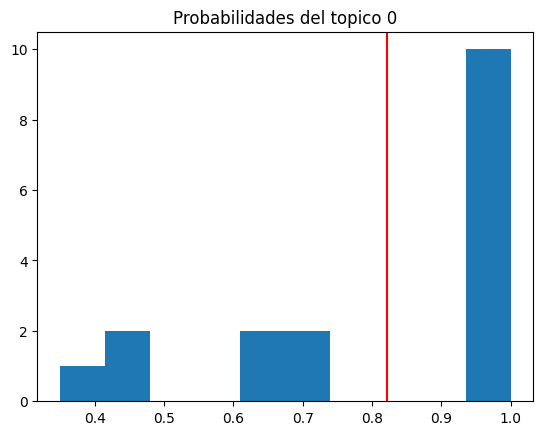

In [45]:
import matplotlib.pyplot as plt

df_corte = pd.DataFrame((zip(topics_1,probs_1)), columns = ['topicos','probabilidades'])

n_topic = 1
df_corte = df_corte[df_corte["topicos"] == n_topic]
probs_1_0 = list(df_corte["probabilidades"])


plt.title(f"Probabilidades del topico 0")
plt.hist(probs_1_0)
plt.axvline(np.mean(probs_1_0), color = "red")
filtro = np.mean(probs_1_0)



### Muestro los cortes para cada Topico

In [46]:
df_corte_p = pd.DataFrame((zip(topics_1,probs_1)), columns = ['topicos','probabilidades'])
n_topic = len(topic_model_1.get_topics().keys())-1
cortes = []


for topic  in range(0, n_topic):
      probs = list(df_corte_p[df_corte_p["topicos"] == topic]["probabilidades"])
      prom = [np.mean(probs).round(3)]
      cortes.append(prom)

topicos_num =list(range(0,n_topic))
df_cortes = pd.DataFrame((zip(topicos_num,cortes)), columns = ['Topico','Corte'])
df_cortes

,Topico,Corte
0,0,[0.981]
1,1,[0.821]


### De cada topico traigo los documentos cuya probabilidad de pertenecer al topico sea mayor al threshold

In [47]:
df_modelo_1= pd.DataFrame((zip(topics_1,probs_1,proc_data_text_1)), columns = ['topicos','probabilidades',"Texto"])

In [48]:
#Ingrese numero de topico
topico= 1


corte = df_cortes[df_cortes["Topico"] == topico] 
corte = list(corte["Corte"])
corte= corte[0][0]
corte

df_modelo_1_filtrado = df_modelo_1[(df_modelo_1["probabilidades"]> corte)  &  (df_modelo_1["topicos"] == topico) ]

print(f"Los documentos del topico {topico} con probabilidad mayor al corte {corte}  son:")
df_modelo_1_filtrado.sort_values("probabilidades", ascending=False).head(5) 



Los documentos del topico 1 con probabilidad mayor al corte 0.821  son:


,topicos,probabilidades,Texto
22,1,1.0,RN senador Ohio pasó acérrimo crítico expresid...
122,1,1.0,intención generar polémica ocurrido semana Est...
189,1,1.0,videos Atentado Trump muestra gente alertó ser...
229,1,1.0,FBI Estados Unidos identificó Thomas Matthew C...
325,1,1.0,secuencia muestra enorme dimensión disparo ido...


### Traigo los  mejores documentos para cada topico.

In [49]:
## Aca no se como consultar al elastic. Creo que  haria falta
n_topic = len(topic_model_1.get_topics().keys())-1


for topico in range(0, n_topic):
    doc_representativos= topic_model_1.get_representative_docs(topico)
    print(doc_representativos)

['Diego Canepa cobertura especial red InfoNegocios Agentina consagró campeón CONMEBOL Copa América™ vencer Colombia partido emocionante durísimo literalmente película culminó gol Lautaro Martínez extra asegurando victoria 1 0 revalidando título obtenido 2021 Argentina gana decimasexta torneo viejo importante continente proyecta dueño título selección títulos internacionales mundo Diego Canepa cobertura especial red InfoNegocios Agentina consagró campeón CONMEBOL Copa América™ vencer Colombia partido emocionante durísimo literalmente película culminó gol Lautaro Martínez extra asegurando victoria 1 0 revalidando título obtenido 2021 Argentina gana decimasexta torneo viejo importante continente proyecta dueño título selección títulos internacionales mundo encuentro disputado 15 julio 2024 Miami medio ciudad organización superada pasión desorden locura fútbol escenario consagración Argentina máximo ganador Copa América 16 títulos historial dirección Lionel Scaloni equipo argentino logró c

### Traigo para un documento cualquiera el texto más cercano.

In [50]:
# Escriba el nuevo documento
new_doc = "Donals Trump, presidente de EEUU, sufrio un atentado como muestra la foto"
#new_doc = "Argentina copa America seleccion"

new_doc_embed = topic_model_1.embedding_model.embed(new_doc)

#new_doc_embed

query = {
        "size": 10,
        "query": {
            "knn": {
            "vector": {
                    "vector": list(new_doc_embed),
                    "k": 2
                }
            }
        }
    }

response = os_client.search(index="topic", body=query)  
documents = response['hits']['hits']
type(documents)
len(documents)
print(documents[0].get("_source").get("best_doc"))


c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Menú No te pierdas las últimas noticias Seguinos en las redes sociales Por La Opinión Austral Your browser doesn’t support HTML5 audio La Selección Argentina dirigida por Lionel Scaloni marcó otro hito es la historia, es que los ahora bicampeones de América se consagraron como la selección más ganadora del continente. Pese a lo entrada la noche -ya que el partido comenzó una hora tarde y se extendió hasta por dos tiempos complementarios- los vecinos de Río Gallegos no quisieron privarse del festejo y un copioso grupo se concentró en la emblemática esquina de las Av. Néstor Kirchner y San Martín.     Leé más notas de La Opinión Austral Noticias relacionadas Compartir esta noticia LO MÁS LEÍDO Seguínos en redes ¡No te pierdas las noticias destacadas de La Opinión Austral! Recibí las historias más importantes del día Al suscribirse al newsletter acepta nuestros términos y condiciones y política de privacidad.   Dejanos tu comentario Más noticias  Cerrar © Copyright  La Opinión Austral ® T

### Inicializa el modelo para el corpus 2 y lo entreno para dicho dataset.

In [51]:

vectorizer_model_2= tfidf_vectorizer_2

topic_model_2 = BERTopic(
  embedding_model=embedding_model,              
  umap_model=umap_model,                        
  hdbscan_model=hdbscan_model,                  
  vectorizer_model=vectorizer_model_2,          
  ctfidf_model=ctfidf_model,                    
  # language='multilingual',                    
  verbose=True,
  # calculate_probabilities=True
)










In [52]:
topics_2, probs_2 = topic_model_2.fit_transform( proc_data_text_2)

2024-09-30 11:28:24,404 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-09-30 11:29:14,001 - BERTopic - Embedding - Completed ✓
2024-09-30 11:29:14,001 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-30 11:29:18,801 - BERTopic - Dimensionality - Completed ✓
2024-09-30 11:29:18,807 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-30 11:29:18,907 - BERTopic - Cluster - Completed ✓
2024-09-30 11:29:18,947 - BERTopic - Representation - Extracting topics from clusters using representation models.
c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\bertopic\vectorizers\_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)
2024-09-30 11:29:19,461 - BERTopic - Representation - Completed ✓


In [53]:
print(len(topics_2),len(probs_2))

# Obtener documentos de cada tópico
topic_freq_2 = topic_model_2.get_topic_freq()




#Imprimir el número de tópicos encontrados (incluyendo el tópico -1)
num_topics_2 = len(topic_freq_2)
print(f"Número de tópicos encontrados: {num_topics_2} (incluye el topico -1)")
#print(topic_freq_2)
#print(len(topic_freq_2))


### Recuperar todos los topicos y sus etiquetas generadas por el modelo
# topic_labels_1 = topic_model_1.generate_topic_labels()
# topic_labels_1

500 500
Número de tópicos encontrados: 7 (incluye el topico -1)


### Embedding para el segundo corpus de noticias

In [54]:
embeds_2 = embedding_model.encode(proc_data_text_2)

### Información sobre el segundo modelo

In [55]:
topic_model_2.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,117,-1_personas_ataques_gaza_ciudad,"[personas, ataques, gaza, ciudad, hotel, salud...",[12 personas murieron 31 permanecían desaparec...
1,0,211,0_fútbol_partido_vas_brown,"[fútbol, partido, vas, brown, estadio, liga, a...",[disfrutar contenidos necesario actives JavaSc...
2,1,77,1_soto_catalina_policía_na,"[soto, catalina, policía, na, acidente, nara, ...",[RN situación barilochense Néstor Soto único d...
3,2,47,2_gobierno_andis_presidente_milei,"[gobierno, andis, presidente, milei, fmi, vald...",[gobierno denunció viernes esquema corrupción ...
4,3,23,3_azcuénaga_alsina_lagos_rocha,"[azcuénaga, alsina, lagos, rocha, licencias, c...",[20 julio 2024 Sociedad Dirección Gral Descent...
5,4,14,4_brecha_ccl_mep_suba,"[brecha, ccl, mep, suba, cierre, tasa, precio,...",[año ajo etapa crecimiento vegetativo salir in...
6,5,11,5_misión_nasa_astronautas_armstrong,"[misión, nasa, astronautas, armstrong, marte, ...",[rover Curiosity explorador robótico principal...


### Mergeo ambos modelos

In [56]:
merged_model_1y2 = BERTopic.merge_models([topic_model_1, topic_model_2])

In [57]:
print(f"Número de tópicos del modelo 1:  {len(topic_model_1.get_topic_info()) } (incluye el topico -1)")
print(f"Número de tópicos del modelo 2:  {len(topic_model_2.get_topic_info())} (incluye el topico -1)")
print(f"Número de tópicos del modelo mergeado:  {len(merged_model_1y2.get_topic_info())} (incluye el topico -1)")




Número de tópicos del modelo 1:  3 (incluye el topico -1)
Número de tópicos del modelo 2:  7 (incluye el topico -1)
Número de tópicos del modelo mergeado:  5 (incluye el topico -1)


### Guardo el modelo mergeado

In [58]:
merged_model_1y2.save(r"C:\Users\amunoz\Desktop\NLP_2024\TP"+ "\merge_modelo_1y2")

2024-09-30 11:30:57,789 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


### Junto los embeddings y los documentos

In [59]:
# Junto los embeddings
embeds_1y2 = embeds_1 + embeds_2

# Junto los documentos.
df_train_m =pd.concat([df_train_1, df_train_2])


data_train_1y2= list(df_train_m['text'])

print(f"En el modelo mergeado hay un total de {len(data_train_1y2)} documentos. Es la union de los documentos de los dias anteriores.")

topics_m, probs_m = merged_model_1y2.transform(data_train_1y2)

En el modelo mergeado hay un total de 1000 documentos. Es la union de los documentos de los dias anteriores.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-09-30 11:33:07,487 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [72]:
np.save("embedding1y2", embeds_1y2)
np.save("data_train_1y2", data_train_1y2)


### Calculo los Threshold para cada topico creado en el merge.

In [60]:
df_corte_m = pd.DataFrame((zip(topics_m,probs_m)), columns = ['topicos Merge','probabilidades Merge'])
n_topic_m = len(merged_model_1y2.get_topics().keys())
cortes_m = []


for topic  in range(0, n_topic_m):
      probs = list(df_corte_m[df_corte_m["topicos Merge"] == topic]["probabilidades Merge"])
      prom = [np.mean(probs).round(3)]
      cortes_m.append(prom)

topicos_num =list(range(0,n_topic))
df_cortes_m = pd.DataFrame((zip(topicos_num,cortes_m)), columns = ['Topico Merge','Corte Merge'])
df_cortes_m




c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,Topico Merge,Corte Merge
0,0,[0.448]
1,1,[0.395]


In [61]:
df_m = pd.DataFrame((zip(topics_m,probs_m)), columns = ['topicos mergeados','probabilidades mergeadas'])
num_topics_m = len(merged_model_1y2.get_topics().keys())
threshold_m = []

for topico in range(0,num_topics_m):
    if topico >-1:
        threshold_m.append(np.mean(df_m[df_m["topicos mergeados"] == topico]["probabilidades mergeadas"]))

    


print(len(threshold_m))  
print(threshold_m)
 

5
[0.4476808, 0.39517373, 0.48290926, 0.35664645, nan]


### Matriz de similitud entre noticias y tópicos del merge

In [62]:
sim_matrix_1y2= cosine_similarity(
    merged_model_1y2.topic_embeddings_,
    embeds_1y2
)

### Borro lo guardado para el modelo 1. 

In [63]:
def delete_index_opensearch(index_name: str) -> bool:
    try:
        delete_query = {
                         "query": {"match_all" : {}}

        }
        response = os_client.delete_by_query(index = index_name , body=delete_query)
        return True

    except Exception as e:
        print(f"Ha ocurrido un error: {e}")
        return False
 

delete_index_opensearch("topic")

c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


True

In [45]:
#topics_m, probs_m = merged_model_1y2.transform(data_train_1y2)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-08-27 17:34:35,557 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [64]:
len(topics_m)

1000

### Guardo en opensearch el modelo merge

In [65]:
for topic in merged_model_1y2.get_topics().keys():
    if topic > -1:
        print(topic)
        keywords = merged_model_1y2.topic_representations_[topic]
        topic_keywords = [TopicKeyword(name=k, score=s) for k, s in keywords]


        best_doc_index = sim_matrix_1y2[topic].argmax()

        best_doc = df_train_m.iloc[best_doc_index].text

        topic_doc = Topic(
            vector = list(merged_model_1y2.topic_embeddings_[topic]),
            similarity_threshold = threshold_m[topic],       
            created_at = datetime.now(),
            to_date = parse('2024-07-15'),    # Fechas? 
            from_date = parse('2024-07-16'),
            index = topic,
            keywords = topic_keywords,
            name = get_topic_name(keywords),
            best_doc = best_doc
        )

        print(topic_doc.save())

0
created
1
created
2
created
3
created


In [66]:
# Documentos de un topico
topic = 1 # Validar que exista para la prueba!

docs_per_topics = [i for i, x in enumerate(topic_model_1.topics_) if x == topic]
probs = topic_model_1.probabilities_[docs_per_topics]

print(f"Ejemplo para tópico:{topic} |   {topic_labels_1[topic+1]}")

doc_probs_x_topic = []
for i, doc in enumerate(docs_per_topics):
    doc_probs_x_topic.append([df_1.index[doc], doc, df_1.iloc[doc].title, round(probs[i],4)])
    

df_query_1 = pd.DataFrame(doc_probs_x_topic, columns=['ID','pos_rel','titulo','score']).sort_values('score', ascending=False, ignore_index=True)
print(len(df_query_1), "docs encontrados")
df_query_1

Ejemplo para tópico:1 |   1_trump_presidente_atentado
17 docs encontrados


,ID,pos_rel,titulo,score
0,12176,22,La atajada de Emiliano Martínez que evitó el p...,1.0000
1,1397,325,Un adolescente y un menor protagonizaron una c...,1.0000
2,4967,479,Fue a hacer la previa de la final al Obelisco ...,1.0000
3,6396,422,Información rifa de las parroquias de San José...,1.0000
4,12173,385,Repudios al ataque contra Trump,1.0000
5,12601,122,La selección argentina bicampeona de América,1.0000
6,8584,326,Gesto de dolor y lágrimas: Lionel Messi no pud...,1.0000
7,96,229,Messi se lesiona en un esprint y abandona la f...,1.0000
8,1244,189,Murió un hincha tras caer de una escultura en ...,1.0000
9,2972,491,Tragedia en el Obelisco: murió un hincha de la...,1.0000


,entities,keywords,text
3421,"[Rosa Montero, Voy, Elena Ferrante, Martina Fu...","[amistades extintas, el cariño, mis amigas, af...","Algo imperceptible se quebró, no tenía sentido..."
9010,"[Mendoza, Va, Cámara Insurtech Argentina, La C...","[distintos clientes, la caja, conciencia asegu...","La Cámara Insurtech Argentina, que promueve la..."


### Achico el dataset para reducir tiempo de entrenamiemto

In [27]:
batch_news = 500

df_train_3 = df_3.sample(n=int(batch_news)).copy()

print(f" Cantidad de noticias de df_train_1 es {len(df_train_3)}")

 Cantidad de noticias de df_train_1 es 500


### Entidades y KeyWords con una pequeña limpieza.


In [33]:
from tp_function import  clean_all, Cleaning_text

enti_train_3 = df_train_3["entities"]
enti_train_3_set = list(set([ ent.lower() for sublista in enti_train_3 for ent in sublista ]))
enti_3_clean = clean_all(enti_train_3_set, accents=False)
enti_train_3 = [ word for word in enti_3_clean if word not in SPANISH_STOPWORDS + SPANISH_STOPWORDS_PARTICULAR]
print(len(enti_train_3))
enti_train_3[:5]

key_train_3 = df_train_3["keywords"]
key_3_set = list(set([ keyw.lower() for sublista in key_train_3 for keyw in sublista ]))
key_3_clean = clean_all(key_3_set, accents=False)
key_train_3 = [ word for word in key_3_clean if word not in SPANISH_STOPWORDS+SPANISH_STOPWORDS_PARTICULAR]
print(len(key_train_3))
key_train_3[:5]



3459
9931


['experiencia única',
 'variación mensual',
 'tatuajes',
 'mayores posibilidades',
 'aspirinas']

### Armo el vocabulario 

In [34]:
vocab_3 =  list(set(key_train_3 + enti_train_3))

### TF-IDF

In [35]:
data_train_3 = list(df_train_3['text']) 

tfidf_vectorizer_3 = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 3),
        vocabulary=vocab_3,
)
tfidf_vectorizer_3.fit(data_train_3)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 3),
                vocabulary=['experiencia única', 'variación mensual',
                            'tatuajes', 'aspirinas', 'mayores posibilidades',
                            'actividades culturales', 'guerra',
                            'coloridos trajes', 'alcance lanzados',
                            'la destrucción', 'fútbol femenino',
                            'consejo general', 'atún', 'declaraciones radiales',
                            'deterioro cognitivo', 'maría josé rodríguez',
                            'la izquierda', 'wfn', 'destacado rendimiento',
                            'claudia villafañe', 'rey', 'lecciones',
                            'mac allister', 'garantía', 'cafeína natural',
                            'energía eléctrica', 'pandemia', 'informe policial',
                            'apuestas virtuales', 'media vuelta', ...])

### Limpio el texto de las noticias

In [36]:
data_text_3 = list(df_train_3["text"])

clean_data = Cleaning_text()

proc_data_text_3 = []
for data_in in tqdm(data_text_3):
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_PARTICULAR])
    proc_data_text_3.append(aux)

100%|██████████| 500/500 [00:00<00:00, 1641.63it/s]


In [52]:
#Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model_3= tfidf_vectorizer_3

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# All steps together
topic_model_3 = BERTopic(
  embedding_model=embedding_model,              
  umap_model=umap_model,                        
  hdbscan_model=hdbscan_model,                  
  vectorizer_model=vectorizer_model_3,         
  ctfidf_model=ctfidf_model,                    
  # language='multilingual',                    
  verbose=True,
  # calculate_probabilities=True
)

In [45]:
#def model_function(embedding_model, umap_model, hdbscan_model, vectorizer_model,ctfidf_model):
    #BERTopic(
    #embedding_model=embedding_model,              
    #umap_model=umap_model,                        
    #hdbscan_model=hdbscan_model,                  
    #vectorizer_model=vectorizer_model,         
    #ctfidf_model=ctfidf_model,                    
    #verbose=True,
#)

#topic_model_4 = model_function(embedding_model, umap_model, hdbscan_model, vectorizer_model_3, ctfidf_model)

#topics_1, probs_1 = topic_model_4.fit_transform( proc_data_text_3)

In [53]:
topics_3, probs_3 = topic_model_3.fit_transform( proc_data_text_3)

2024-09-12 11:04:30,877 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/16 [00:00<?, ?it/s]

2024-09-12 11:05:27,384 - BERTopic - Embedding - Completed ✓
2024-09-12 11:05:27,384 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-09-12 11:05:39,385 - BERTopic - Dimensionality - Completed ✓
2024-09-12 11:05:39,385 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-09-12 11:05:39,481 - BERTopic - Cluster - Completed ✓
2024-09-12 11:05:39,507 - BERTopic - Representation - Extracting topics from clusters using representation models.
c:\Users\amunoz\AppData\Local\anaconda3\envs\topics\Lib\site-packages\bertopic\vectorizers\_ctfidf.py:82: RuntimeWarning: divide by zero encountered in divide
  idf = np.log((avg_nr_samples / df)+1)
2024-09-12 11:05:40,755 - BERTopic - Representation - Completed ✓


In [54]:
df_modelo_3 = pd.DataFrame((zip(topics_3,probs_3,proc_data_text_3)), columns = ['topicos','probabilidades',"Texto"])
df_modelo_3.head(2)

,topicos,probabilidades,Texto
0,0,0.962761,Astrotoons es una experiencia cooperativa Un s...
1,0,1.000000,Junto al intendente Gustavo Barrera visitaron ...


In [55]:
topic_freq_3 = topic_model_3.get_topic_freq()
num_topics_3 = len(topic_freq_3)
print(f"Número de tópicos encontrados: {num_topics_3} (incluye el topico -1)")
print(topic_freq_3)
print(len(topic_freq_3))




Número de tópicos encontrados: 2 (incluye el topico -1)
   Topic  Count
0      0    473
1      1     27
2


In [56]:
embeds_3 =  embedding_model.encode(proc_data_text_3)